<img align="right" src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png" style="height: 100px; width:300px;"/>
<img align="left" src="../theme/mowgli_logo.png" style="height: 150px; width:200px;"/>

# <h3 align="center">**Notebook Random Forest - Projet Mowgli**</h3> 

 Ce notebook a pour but de montrer **l'impl√©mentation du mod√®le Random Forest** et des principaux param√®tres √† tuner afin d'am√©liorer les performances du mod√®le.

 <div class="alert alert-block alert-danger">
    Dans ce notebook, l'attention est port√©e sur le mod√®le de Random Forest. <b>La d√©marche d'√©valuation du mod√®le est loin d'√™tre parfaite et sera trait√©e dans un autre notebook</b>.
</div>

In [1]:
# Base
from pathlib import Path

# Preprocessing
import numpy as np
import pandas as pd

# Modelling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## **1. Preprocessing**

### **1.1. Chargement des donn√©es**

**Donn√©es : Base de consommation √©lectrique - MA**

In [2]:
PROJECT_PATH = Path("/dataspacefull_share/transverse/Mowgli/dev/")

In [3]:
data_reg = pd.read_csv(
    PROJECT_PATH / "data" / "base_regression1.csv", sep=";", decimal=","
)

In [4]:
numerical_cols = [
    "NB_ANNEE_CREATION_ET",
    "NB_ANNEE_CREATION_EN",
    "SIREN_NB_SIRET",
    "SIRET_TRANCHE_EFFECTIF_CONSOLIDE",
    "SIREN_TRANCHE_EFFECTIF_CONSOLIDE",
    "DEPT_SECT_CONSOMMATION_MWH",
    "NOMBRE_BATI",
    "SURFACE_AU_SOL_TOTALE",
    "SURFACE_PLANCHER_TOTALE",
    "SURFACE_AU_SOL_PONDEREE",
    "SURFACE_PLANCHER_PONDEREE",
    "SCORE_IGN",
    "NBRE_SIRET_ADR",
    "latitude",
    "longitude",
    "DEPT_DJU",
    "ZONE_URBAINE",
]
categorical_cols = [
    "SIEGE",
    "BRANCHE",
    "SOUS_BRANCHE",
    "SIREN_CA_SUP_1MILLION_EUR",
    "ZONE_CLIMATIQUE",
]
other_cols = ["SIRET", "SIRET_CONSOMMATIONMWH_ANNUELLE"]
# unused_cols = ['Unnamed: 0', 'SIREN', 'LIBAPET', 'NJ', 'L4_NORMALISEE', 'L6_NORMALISEE', 'DEPET', 'NAF_SECT_ET', 'NJ1', 'SIREN_RISQUE', 'NIV1NAF', 'NIV2NAF', 'FLAG_BRANCHE_TERTIAIRE', \
#                'APET700', 'SOUS_BRANCHE']
unused_cols = [
    "SIREN",
    "NAF_SECT_ET",
    "NJ1",
    "SIREN_RISQUE",
    "NIV1NAF",
    "NIV2NAF",
    "FLAG_BRANCHE_TERTIAIRE",
    "APET700",
]

data_reg = data_reg[data_reg.SURFACE_PLANCHER_PONDEREE != 0]
data_reg = data_reg[data_reg.SURFACE_AU_SOL_PONDEREE != 0]
data_reg = data_reg[data_reg.SIRET_CONSOMMATIONMWH_ANNUELLE > 0]

In [5]:
data_reg = data_reg.astype(
    {
        "NB_ANNEE_CREATION_ET": "float64",
        "NB_ANNEE_CREATION_EN": "float64",
        "DEPT_SECT_CONSOMMATION_MWH": "float64",
    }
)
data_reg = data_reg[~data_reg["SIRET_CONSOMMATIONMWH_ANNUELLE"].isna()]
data_reg = data_reg[data_reg.FLAG_BRANCHE_TERTIAIRE == 1]


data_reg = data_reg[data_reg.SURFACE_PLANCHER_PONDEREE != 0]
data_reg = data_reg[data_reg.SURFACE_AU_SOL_PONDEREE != 0]
data_reg = data_reg[data_reg.SIRET_CONSOMMATIONMWH_ANNUELLE > 0]

In [6]:
# Surfaces to log(Surfaces)

data_reg["SURFACE_AU_SOL_PONDEREE"] = np.log10(data_reg["SURFACE_AU_SOL_PONDEREE"])
data_reg["SURFACE_PLANCHER_PONDEREE"] = np.log10(data_reg["SURFACE_PLANCHER_PONDEREE"])
data_reg["SURFACE_AU_SOL_TOTALE"] = np.log10(data_reg["SURFACE_AU_SOL_TOTALE"])
data_reg["SURFACE_PLANCHER_TOTALE"] = np.log10(data_reg["SURFACE_PLANCHER_TOTALE"])

# Conso to log(Conso)

data_reg["SIRET_CONSOMMATIONMWH_ANNUELLE"] = np.log10(
    data_reg["SIRET_CONSOMMATIONMWH_ANNUELLE"]
)

In [7]:
transfo = data_reg.copy(deep=True)
transfo.drop(unused_cols, axis=1, inplace=True)

### **1.2. Train/Test split**

In [8]:
train, test = train_test_split(transfo, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

### **1.3. Cr√©ation du Pipeline de preprocessing**

In [9]:
# on d√©finit les colonnes et les transformations pour les colonnes quantitatives
numerical_cols

transfo_quanti = Pipeline(
    steps=[
        # ('remove_outliers',OutlierRemover(factor=1.5)),
        ("imputation", SimpleImputer(strategy="median")),
        ("standard", StandardScaler()),
    ]
)

# on d√©finit les colonnes et les transformations pour les variables qualitatives
categorical_cols

transfo_quali = Pipeline(
    steps=[
        # ('rare_values',RareValuesGrouper(threshold=0.05)),
        ("imputation", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# on d√©finit l'objet de la classe ColumnTransformer qui va permettre d'appliquer toutes les √©tapes
preparation = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        ("quanti", transfo_quanti, numerical_cols),
        ("quali", transfo_quali, categorical_cols),
    ],
)

In [10]:
# On fit-transforme le train
train_transformed = preparation.fit_transform(train)

# On transforme la validation
val_transformed = preparation.transform(val)

# On transforme le test
test_transformed = preparation.transform(test)

In [11]:
# On r√©cup√®re les noms des colonnes onehot encod√©es
categorical_onehotenc_cols = (
    preparation.transformers_[1][1][1].get_feature_names_out().tolist()
)

# On transforme la matrice r√©sultante de la transformation en dataframe
train_transformed = pd.DataFrame(
    train_transformed, columns=numerical_cols + categorical_onehotenc_cols + other_cols
)

val_transformed = pd.DataFrame(
    val_transformed, columns=numerical_cols + categorical_onehotenc_cols + other_cols
)

test_transformed = pd.DataFrame(
    test_transformed, columns=numerical_cols + categorical_onehotenc_cols + other_cols
)

In [12]:
feature_cols = [
    x
    for x in train_transformed.columns
    if x not in ["SIRET", "SIRET_CONSOMMATIONMWH_ANNUELLE"]
]

In [13]:
def get_dataset(df):
    X = df.loc[:, feature_cols]
    y = df["SIRET_CONSOMMATIONMWH_ANNUELLE"]
    return X, y

In [14]:
X_train, y_train = get_dataset(train_transformed)
X_val, y_val = get_dataset(val_transformed)
X_test, y_test = get_dataset(test_transformed)

## **2. Mod√©lisation**

### **2.1. D√©finition du mod√®le du RandomForest**

L‚Äôalgorithme des ¬´ for√™ts al√©atoires ¬ª (ou ¬´ Random Forest ¬ª) permet de combiner un grand nombre d‚Äôarbres de d√©cision o√π chaque arbre est entrain√© sur des sous-ensembles de donn√©es diff√©rents selon une approche de type ¬´ bagging ¬ª, c‚Äôest-√†-dire par tirage al√©atoire avec remise, et uniquement sur un sous ensemble de variables choisies de mani√®re al√©atoire. 

Cet algorithme est l‚Äôun des mod√®les les plus efficaces pour les donn√©es tabulaires et n√©cessite tr√®s peu de pr√©traitement de donn√©es. Il a permis d‚Äôam√©liorer significativement les performances de notre estimation de la consommation.

### **2.2. Impl√©mentation du mod√®le**

Ici nous allons traiter une probl√©matique de type r√©gression, nous allons donc utiliser la classe issue de sklearn `RandomForestRegressor`.

Dans le cadre d'une classification, c'est la classe `RandomForestClassifier` qui devra √™tre utilis√©e.

Dans un premier temps, nous allons impl√©menter **un mod√®le Random Forest simple**, en param√©trant uniquement le nombre d'arbres `n_estimators`. Le nombre d'arbres est le param√®tre le plus important pour un mod√®le de Random Forest.
: 

In [15]:
from sklearn.ensemble import RandomForestRegressor

# from sklearn.ensemble import RandomForestClassifier # √† utiliser dans le cadre d'une classification

In [16]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train);

In [17]:
y_train_predicted = rf.predict(X_train)
y_val_predicted = rf.predict(X_val)

#### **Importance des variables**

L'impl√©mentation des Random Forest dans scikit-learn permet d'obtenir facilement l'importance des features. 
Par contre, la [m√©thode impl√©ment√©e de calcul de l'importance des features](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_) donne souvent des r√©sultats biais√©s. <b>Des m√©thodes d'explicabilit√© plus robustes sont abord√©es dans le notebook d'explicabilit√©.

Pour plus d'informations sur les limites de la m√©thode de calcul d'importances impl√©ment√©e par d√©faut dans scikit-learn: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

<hr></hr>
L'importance des variables est normalis√©e, la somme de l'importance de toutes les colonnes est √©gale √† 1.

In [18]:
rf.feature_importances_

array([9.52805309e-03, 9.28925732e-03, 5.20254418e-03, 7.56387239e-03,
       5.45733923e-03, 7.64987300e-03, 2.51688733e-03, 8.63281818e-03,
       8.16402560e-03, 8.75018570e-03, 7.87445251e-01, 1.94776779e-03,
       5.65143846e-03, 9.79292471e-03, 9.79933080e-03, 6.44589284e-03,
       6.28493283e-03, 4.71296719e-04, 4.99440540e-04, 3.65345212e-03,
       5.25254557e-03, 1.42590879e-02, 8.16186846e-04, 3.43182261e-04,
       4.77784023e-04, 2.62873798e-04, 1.56549250e-04, 2.57723126e-03,
       1.52020930e-03, 2.15450720e-02, 2.01315851e-03, 4.27839700e-03,
       8.73784647e-04, 1.48559579e-03, 6.97512821e-04, 6.23464971e-04,
       6.21806268e-04, 9.06877677e-03, 9.26949152e-05, 9.84822903e-03,
       9.92764397e-04, 4.89497833e-03, 1.74898675e-03, 7.28493614e-04,
       2.32341826e-03, 3.83678262e-04, 2.68115297e-03, 5.69221553e-04,
       3.49965531e-04, 1.49388905e-04, 8.26117958e-04, 8.01292969e-04,
       8.16017816e-04, 7.88486886e-04, 3.85309369e-04])

<AxesSubplot:>

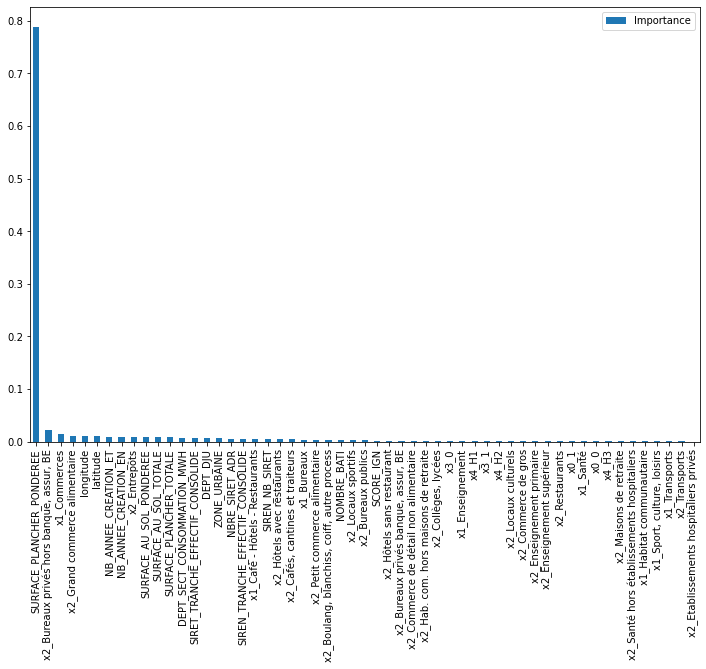

In [19]:
feat_importances = pd.DataFrame(
    rf.feature_importances_, index=feature_cols, columns=["Importance"]
)
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)
feat_importances.plot(kind="bar", figsize=(12, 8))

**Performances :**

In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_score(y_train, y_train_predicted)

0.9820485807322747

In [22]:
r2_score(y_val, y_val_predicted)

0.8687992173790564

En comparant **les deux scores obtenus sur l'ensemble d'apprentissage et l'ensemble de test**, nous remarquons que le mod√®le **overfitte**.

Afin d'√©viter ce ph√©nom√©ne, nous allons **tuner diff√©rents param√®tres** de notre mod√®le en construisant un **GridSearch** dans la section suivante et nous allons comparer les diff√©rentes performances. 

#### **Incertitude des pr√©dictions**

Comme le random forest est un mod√®le d'ensemble d'arbres de d√©cision, pour pr√©dire le r√©sultat d'un point donn√©, on fait passer le point en question par tous les arbres de d√©cision.

Dans le cas de r√©gression, la pr√©diction finale du random forest est la moyenne des pr√©dictions des arbres de d√©cision. Pour avoir **une id√©ee de l'incertitude de la pr√©diction**, on peut aussi calculer **l'√©cart-type des pr√©dictions des arbres de d√©cision**.

Dans les lignes de code ci-dessous, on r√©alise le calcul pour le *premier point du train set*. Le calcul peut tr√®s bien √™tre fait pour tous les points du jeu de donn√©es.

In [23]:
# On calcule la pr√©diction de chaque arbre de d√©cision
all_estimators_preds = np.stack(
    [t.predict(X_train.loc[[0]].to_numpy()) for t in rf.estimators_]
)

La moyenne des pr√©dictions des arbres de d√©cision constituant le random forest correspond √† la pr√©diction du random forest.

In [24]:
# Pr√©diction du random forest
rf.predict(X_train.loc[[0]])

array([1.73960724])

In [25]:
# Moyenne des pr√©dictions
np.mean(all_estimators_preds)

1.7396072406666878

L'√©cart-type des pr√©dictions peut √™tre calcul√© ainsi:

In [26]:
np.std(all_estimators_preds)

0.09035933682146148

In [27]:
print(
    f"La pr√©diction du mod√®le pour ce point est {rf.predict(X_train.loc[[0]]).item():.3f} ¬± {np.std(all_estimators_preds):.3f}"
)

La pr√©diction du mod√®le pour ce point est 1.740 ¬± 0.090


Un **intervalle de confiance de la pr√©diction √† 95%**  peut √©galement √™tre calcul√©.

In [28]:
np.quantile(all_estimators_preds, [0.025, 0.975])

array([1.53623696, 1.89925726])

### **2.3. Impl√©mation via GridSearch**

Cette approche peut se r√©v√©ler **tr√®s performante**, elle consiste √† utiliser la recherche par quadrillage. 

Son impl√©mentation est plut√¥t simple, l'id√©e est de donner **une liste de valeurs pour chacun des hyper-param√®tres** et pour chacune des combinaisons, un mod√®le sera entraine√©, pour conserver √† la fin celui avec **le meilleur score**. 

<div class="alert alert-block alert-success"><b>
    NB :</b> D'autres alternatives existent pour tuner les hyperparam√®tres telles que l'utilisation de la recherche al√©atoire d'hyperparam√®tres `RandomizedSearchCV` ou les m√©thodes de recherche bay√©siennes.</div>

#### **Param√®tres √† tuner**

Nous retrouvons ci-dessous **une description des param√®tres importants** lors de l'entrainement d'un mod√®le de RandomForest :

- **n_estimators**: Nombre d'abres de d√©cision √† entrainer dans le mod√®le. Dans le cas o√π l'entrainement se fait sur un grand nombre d'arbres, il permet d'avoir de meilleures performances mais rend l'ex√©cution beaucoup plus lente et augmente le risque d'overfitting.

- **max_features**: Nombre maximal des variables √† consid√®rer lors de chaque split. En limitant le nombre de features pour chaque arbre, ceci pourrait r√©duire la performance de chaque arbre mais a le grand avantage de produire des arbres d√©corr√©l√©s entre eux. Il est souvent conseill√© de prendre la racine carr√© du nombre de features du dataset.
<br>Si on utilise tous les features et que la liste des variables contient une variable avec un fort pouvoir pr√©dictif, on risque de toujours avoir cette variable au niveau du premier split des arbres, et donc avoir des arbres trop similaires.

- **max_depth**: Profondeur maximale de chaque arbre du mod√®le. Il correspond au chemin le plus long entre le noeud "root" et le noeud "terminal". Ce param√®tre permet de r√©duire la complexit√© du mod√®le, en r√©duisant ainsi le risque d'overfitting.

- **min_samples_leaf**: Nombre minimal d'√©chantillons de donn√©es requis pour √™tre dans un noeud "terminal". Ce param√®tre influence aussi la profondeur max de l'arbre et permet √©galement de r√©duire le risque d'overfitting. 

- **bootstrap**: [`True` ou `False`] Choix de la strat√©gie d'√©chantillonage, avec ou sans remise. Dans le mod√®le RF, par d√©faut, l'√©chantillonage sera effectu√© avec remise. Si `boostrap` est √©gal √† `False`, toutes les donn√©es seront utilis√©es pour entrainer chaque arbre de d√©cision, il n'y a donc pas de variation al√©atoire entre les arbres par rapport aux exemples s√©lectionn√©s √† chaque √©tape. Cependant, la for√™t al√©atoire a une deuxi√®me source de variation, qui est le sous-ensemble al√©atoire de variables √† consid√©rer lors de chaque split.

- **oob_score**: [`True` ou `False`] Quand bootstrap est √©gale √† `True`, chaque arbre est entrain√© sur un √©chantillon (√©chantillonage avec remise) des donn√©es. Le reste des lignes faisant partie du training set n'est donc pas utilis√© lors de l'entrainement par l'arbre. Ces lignes l√† constituent **l'√©chantillon Out-of-bag** et peuvent donc √™tre utilis√©es de mani√®re √©quivalent √† un validation set.
<br>Chaque arbre peut donc √™tre √©valu√© sur son √©chantillon out-of-bag et le r√©sultat peut √™tre consid√©r√© comme un score de validation. Le `oob_score` correspond au score par d√©faut du mod√®le sur l'√©chantillon out-of-bag. Cette mesure est **pratique surtout quand le jeu de donn√©es a une taille limit√©e et le validation set ne peut pas √™tre construit**.
<br>D'autres m√©triques peuvent √™tre calcul√©es sur l'√©chantillon out-of-bag en utilisant `oob_prediction_`.

- **n_jobs**: Nombre de CPUs utilis√©s lors de l'entrainement.

- **random_state**: Choix du facteur al√©atoire. Il s'agit du param√®tre qui assure que les r√©sultats obtenus soient reproductibles √©tant donn√© la nature al√©atoire du mod√®le RF. 

- **verbose**: Permet d'afficher des informations plus ¬´ d√©taill√©es ¬ª pour la t√¢che execut√©e.




Pour **impl√©menter le GridSearch** avec Scikit-Learn,  il suffit de cr√©er un dictionnaire Python "param_grid" avec les hyper-param√®tres a param√©trer et les valeurs qu'on souhaite tester.

Dans le mod√®le de random forest, tous les param√®tres n'apportent pas un vrai gain de performance. G√©n√©relement, il suffit de tuner les param√®tres suivants:
- **n_estimators**: Le nombre d'arbres est g√©n√©ralement le param√®tre le plus important lors de l'entrainement d'un mod√®le de random forest. Parfois, il convient de commencer par un test de plusieurs valeurs du nombre d'estimateurs afin de d√©terminer le nombre d'estimateurs n√©cessaires pour overfitter. Une fois que ce seuil est d√©termin√©, les param√®tres ci-dessous vont permettre de r√©gulariser le mod√®le.

- **min_samples_leaf**
- **max_depth**
- **max_features**: Quand le nombre d'arbres est grand, la diff√©rence entre les deux otpions de scikit-learn, en l'occurrence `log2` et `sqrt` est minime.

**<font color='red'>Remarque:</font>** Parfois, le param√®tre `min_impurity_decrease` est utilis√© pour r√©gulariser les random forest. `min_impurity_decrease` permet de n'ajouter de split que si le split permet un certain gain de performance. Ceci ne prend pas donc en compte l'interaction entre les variables. Il arrive que le premier split ne soit pas optimal mais que l'ensemble de deux splits cons√©cutifs permette de bien discriminer les donn√©es

Dans notre cas, nous allons **entrainer une GridSearch avec 240 combinaisons de param√®tres diff√©rents**, cela signifie que **nos donn√©es seront entrain√©s sur 120 mod√®les.**

In [29]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 300, 500],
    "min_samples_leaf": [1, 5, 10],
    "max_depth": [2, 4, 6, 8, 10],
    "max_features": ["auto", "sqrt"],
}

rf_model = RandomForestRegressor(oob_score=True)

model_gridsearch = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=4,
    refit=True,
    return_train_score=True,
)

Ensuite nous allons **entrainer la classe GridSearchCV** avec la **m√©thode "fit()"**.

**<font color='red'>Remarque:</font>** Comme on passe par la validation crois√©e et qu'on a en plus le oob_score, on va cr√©er un nouveau train set qui correspond √† l'ancien train set augment√© de la validation set.
Cette d√©marche n'est pas correcte √† 100% vu que le pipeline de transformation de donn√©es n'a √©t√© entrain√© que sur le train set mais √ßa nous √©vitera de refaire le pipeline (et donc de gagner du tempsüòÖ)

In [30]:
import time

start = time.time()
model_gridsearch.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % ((time.time() - start), len(model_gridsearch.cv_results_["params"]))
)

GridSearchCV took 819.55 seconds for 120 candidate parameter settings.


Une fois le mod√®le impl√©ment√© et entrain√©, nous analysons **les performances du mod√®le sur l'ensemble d'apprentissage ainsi que sur l'ensemble de test** comme suit :

In [31]:
y_train_grid = model_gridsearch.predict(pd.concat([X_train, X_val]))
r2_score(pd.concat([y_train, y_val]), y_train_grid)

0.8884169819343597

On calcule le score OOB qui est √©quivalent au score de validation. La valeur du score OOB va nous permettre de voir si le mod√®le overfitte.

In [32]:
model_gridsearch.best_estimator_.oob_score_

0.8621597585405792

On voit que les param√®tres issus du grid search ont permis de r√©duire l'overfitting.

Suite √† **l'impl√©mentation du GridSearch**, nous obtenons **le mod√®le et les hyper-param√®tres qui permettent d'avoir une tr√®s bonne performance sur nos donn√©es.** 

Nous arrivons √† avoir **des performances semblables sur l'ensemble d'apprentissage et sur l'ensemble de validation** ce qui nous permet d'√©viter le probl√®me d'overfitting survenu au niveau de la premi√®re partie du notebook dans l'impl√©mentation du mod√®le de RandomForest simple en param√®trant uniquement le nombre d'arbres de d√©cisions √† entrainer "n_estimators".

Maintenant, on √©value la performance du **mod√®le retenu** sur le test set pour avoir les performances du mod√®le.

In [33]:
y_pred_grid = model_gridsearch.predict(X_test)
r2_score(y_test, y_pred_grid)

0.8605156388045487

<hr>
Nous trouverons ci-dessous quelques **propri√©t√©s utilses afin d'acc√®der aux diff√©rents √©l√©ments du GridSearch** :

La fonction **"cv_results_"** permet d'obtenir **les r√©sultats de la cross validation :**

In [ ]:
print("Best Results:", model_gridsearch.cv_results_)

La fonction **"best_score_"** permet de renvoyer **le meilleur score suite √† la cross validation :**

In [35]:
print("Best Score:", model_gridsearch.best_score_)

Best Score: 0.8612346539373587


La fonction **"best_params_"** permet d'obtenir **les hyper-param√®tres permettant d'avoir le meilleur score :**

In [36]:
print("Best params:", model_gridsearch.best_params_)

Best params: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}


On voit que le mod√®le final correspond au mod√®le avec le minimum de r√©gularisation au niveau de la grille et que le mod√®le n'overfitte pas

La fonction **"best_estimator_"** permet de stocker **le mod√®le le plus performant :**

In [37]:
print("Best estimator:", model_gridsearch.best_estimator_)

Best estimator: RandomForestRegressor(max_depth=10, n_estimators=500, oob_score=True)
